# Modeling of Complex Biological Systems  - Homework 4

For the homework for Modeling of Complex Biological Systems class, I applied the MLP to MNIST Fashion dataset, both using densely connected layers and convolutional layers

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from datetime import datetime

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from PIL import Image

In [17]:
# load the dataset
data_dir = 'data/fashion/'

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.FashionMNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

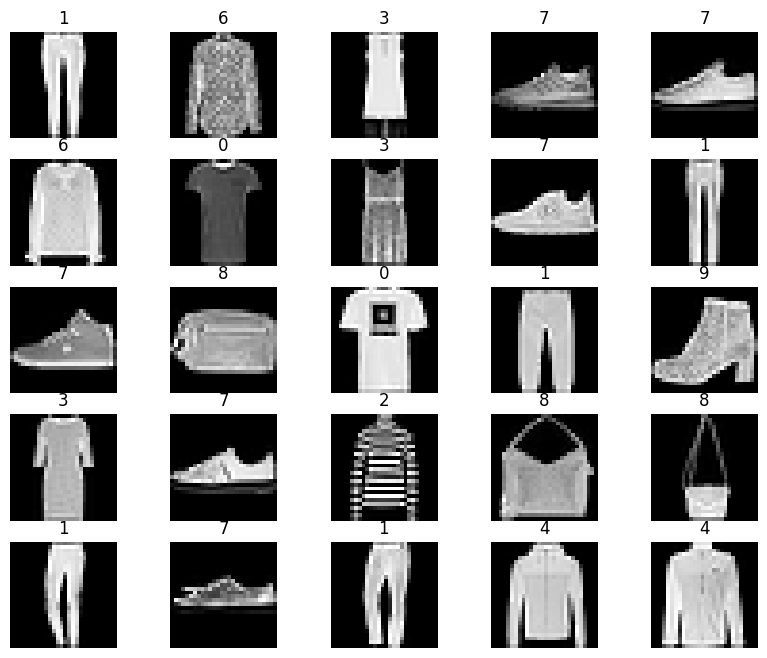

In [16]:
# Print multiple images at once
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Training and validation data
While building a ML/DP models, it is common to split the dataset into 3 parts:

*   Training set - to train the model, compute the loss and adjust the weights of the model using gradient descent.
*   Validation set - to evalute the traing model, adjusting the hyperparameters and pick the best version of the model.
*   Test set - to final check the model predictions on the new unseen data to evaluate how well the model is performing.

Quite often, validation and test sets are interchanged (i.e., the validation set is used to final check the model predictions...). Read carefully of the setup.

Following adapted from [Kaggle notebook](https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch)

In [18]:
train_data, validation_data = random_split(train_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)
## MNIST data from pytorch already provides held-out test set!

length of Train Datasets:  50000
length of Validation Datasets:  10000


## Multi-class Logistic Regression (a building block of DNN)

We define the class with multiple methods so that we can train, evaluate, and do many other routine tasks with the model.

Particularly, we are looking at multi-class logistic regression (a generalization of one-class logistic regression) using the softmax function (more about this in a few cells down)

In [22]:
input_size = 28 * 28
num_classes = 10

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        # view xb with two dimensions, 28 * 28(i.e 784)
        # One argument to .reshape can be set to -1(in this case the first dimension),
        # to let PyTorch figure it out automatically based on the shape of the original tensor.
        xb = xb.reshape(-1, 784)
        print(xb)
        out = self.linear(xb)
        print(out)
        return(out)

model = MnistModel()
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0250,  0.0025,  0.0266,  ..., -0.0085, -0.0258,  0.0148],
         [-0.0089, -0.0264,  0.0341,  ..., -0.0057, -0.0159, -0.0199],
         [ 0.0224, -0.0058,  0.0033,  ..., -0.0301,  0.0161,  0.0004],
         ...,
         [-0.0036,  0.0290,  0.0246,  ...,  0.0276,  0.0026,  0.0184],
         [ 0.0201,  0.0069,  0.0029,  ...,  0.0326,  0.0224, -0.0046],
         [-0.0072,  0.0106,  0.0131,  ..., -0.0043,  0.0291,  0.0105]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0125,  0.0262, -0.0266,  0.0024,  0.0310,  0.0283, -0.0119,  0.0271,
         -0.0112,  0.0345], requires_grad=True)]

In [23]:
# Alway check the dimensions and sample data/image
for images, labels in train_loader:
    outputs = model(images)
    break

print('Outputs shape: ', outputs.shape) # torch.Size([128, 10])
print('Sample outputs: \n', outputs[:2].data) # example outputs

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[-0.5298, -0.6015, -0.3762,  ..., -0.2998,  0.1254,  0.5387],
        [-0.4775, -0.5273, -0.1510,  ..., -0.3282,  0.1104,  0.2793],
        [-0.4279, -0.5754, -0.4024,  ..., -0.1723,  0.0263,  0.2217],
        ...,
        [-0.6382, -0.8670, -0.3936,  ..., -0.2465,  0.2348,  0.5812],
        [-0.4903, -0.3988, -0.2292,  ..., -0.1605, -0.0152,  0.1878],
        [-0.2245, -0.7505, -0.1797,  ..., -0.1258,  0.0644,  0.4109]],
       grad_fn=<AddmmBackward0>)
Outputs shape:  torch.Size([128, 10])
Sample outputs: 
 tensor([[-0.5298, -0.6015, -0.3762, -0.2020,  0.2212, -0.4000,  0.5815, -0.2998

## Softmax function


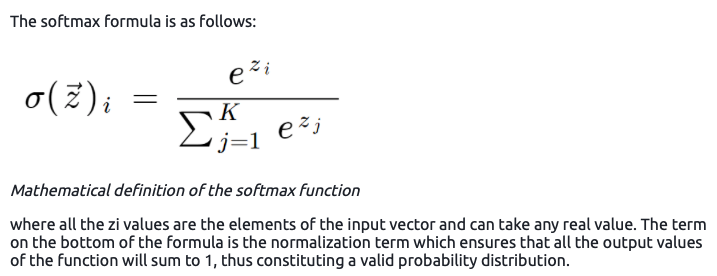

The softmax function is a function that turns a vector of K real values into a vector of K real values that sum to 1. The input values can be positive, negative, zero, or greater than one, but the softmax transforms them into values between 0 and 1, so that they can be interpreted as probabilities. If one of the inputs is small or negative, the softmax turns it into a small probability, and if an input is large, then it turns it into a large probability, but it will always remain between 0 and 1.

The softmax function is sometimes called the softargmax function, or multi-class logistic regression. This is because the softmax is a generalization of logistic regression that can be used for multi-class classification, and its formula is very similar to the sigmoid function which is used for logistic regression. The softmax function can be used in a classifier only when the classes are mutually exclusive.

Many multi-layer neural networks end in a penultimate layer which outputs real-valued scores that are not conveniently scaled and which may be difficult to work with. Here the softmax is very useful because it converts the scores to a normalized probability distribution, which can be displayed to a user or used as input to other systems. For this reason it is usual to append a softmax function as the final layer of the neural network.

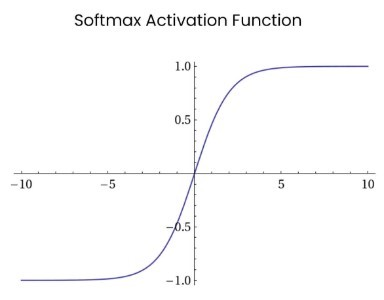

Image from https://insideaiml.com/blog/SoftMaxActivation-Function-1034

In [ ]:
## Apply softmax for each output row
probs = F.softmax(outputs, dim = 1)

## chaecking at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

Sample probabilities:
 tensor([[0.0802, 0.1061, 0.0963, 0.1071, 0.0894, 0.1186, 0.0797, 0.0856, 0.1019,
         0.1352],
        [0.0922, 0.0820, 0.0647, 0.1619, 0.0724, 0.1157, 0.1073, 0.1194, 0.0848,
         0.0996]])


## Evaluation Metric and Loss Function

Here we evaluate our model by finding the percentage of labels that were predicted correctly i.e. the accuracy of the predictions. We can simply find the label with maximum value (before OR after the softmax layer).

NOTE that while accuracy is a great way to evluate the model, it can't be used as a loss function for optimizing our model using gradient descent, because it does not take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for increemental improvements.

Due to this reason accuracy is a great evaluation metric (and human-understanble) for classification metric, but not a good loss function. A commonly used loss function for classification problems is the Cross Entropy (implemented directly, no extra coding required).

In [24]:
# accuracy calculation
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

print("Accuracy: ", accuracy(outputs, labels))
print("\n")
loss_fn = F.cross_entropy
print("Loss Function: ",loss_fn)
print("\n")
## Loss for the current batch
loss = loss_fn(outputs, labels)
print(loss)


Accuracy:  tensor(0.0859)


Loss Function:  <function cross_entropy at 0x0000023BA30F4E00>


tensor(2.3226, grad_fn=<NllLossBackward0>)


## Cross-Entropy
Cross-entropy is commonly used to quantify the difference between two probabilities distribution. Usually the "True" distribution is expressed in terms of a one-hot distribution.

Read more on:


*   https://en.wikipedia.org/wiki/Cross_entropy
*   https://machinelearningmastery.com/cross-entropy-for-machine-learning/
*   https://stackoverflow.com/questions/41990250/what-is-cross-entropy

In [25]:
# We put all of the above:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)

    # We add extra methods
    def training_step(self, batch):
        # when training, we compute the cross entropy, which help us update weights
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        # in validation, we want to also look at the accuracy
        # idealy, we would like to save the model when the accuracy is the highest.
        acc = accuracy(out, labels) ## calculate metrics/accuracy
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        # at the end of epoch (after running through all the batches)
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        # log epoch, loss, metrics
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# we instantiate the model
model = MnistModel()

# a simple helper function to evaluate
def evaluate(model, data_loader):
    # for batch in data_loader, run validation_step
    outputs = [model.validation_step(batch) for batch in data_loader]
    return(model.validation_epoch_end(outputs))

# actually training
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        ## Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() ## backpropagation starts at the loss and goes through all layers to model inputs
            optimizer.step() ## the optimizer iterate over all parameters (tensors); use their stored grad to update their values
            optimizer.zero_grad() ## reset gradients

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [26]:
# test the functions, with a randomly initialized model (weights are random, e.g., untrained)
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.335055112838745, 'val_acc': 0.12549446523189545}

In [ ]:
# let's train for 10 epochs
history_dnn = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6975, val_acc: 0.6173
Epoch [1], val_loss: 1.4149, val_acc: 0.6469
Epoch [2], val_loss: 1.2528, val_acc: 0.6553
Epoch [3], val_loss: 1.1483, val_acc: 0.6625
Epoch [4], val_loss: 1.0750, val_acc: 0.6689
Epoch [5], val_loss: 1.0202, val_acc: 0.6776
Epoch [6], val_loss: 0.9775, val_acc: 0.6886
Epoch [7], val_loss: 0.9431, val_acc: 0.6958
Epoch [8], val_loss: 0.9145, val_acc: 0.7081
Epoch [9], val_loss: 0.8900, val_acc: 0.7155


Text(0.5, 1.0, 'Accuracy over epochs')

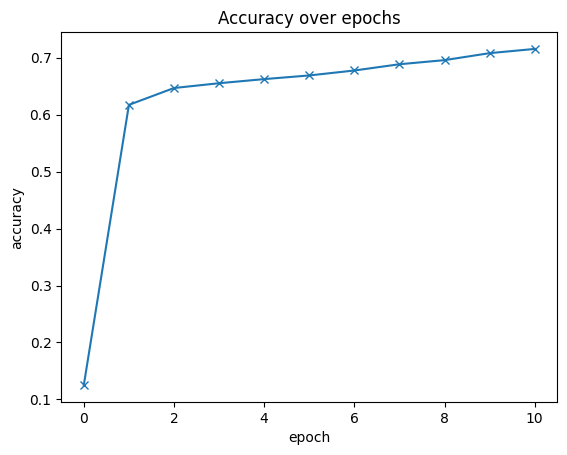

In [ ]:
# we combine the first result (no training) and the training results of 5 epoches
# plotting accuracy
history = [result0] + history_dnn
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

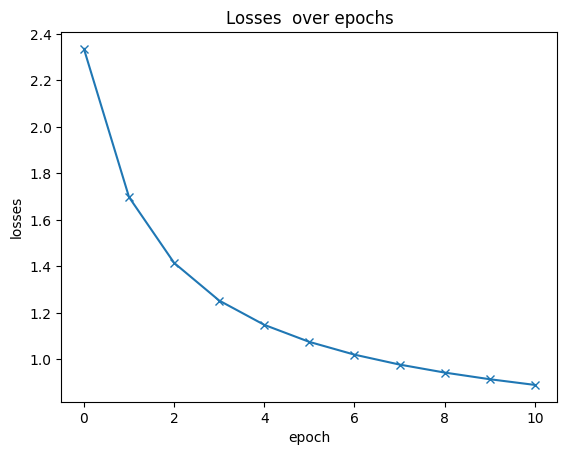

In [ ]:
# plotting losses
history = [result0] + history_dnn
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

## Final check using the (held-out) test dataset.

We will first load the test dataset (from MNIST) and individually check the prediction made by the model. And then, we will put through all images in the test dataset to obtain the final accuracy

Length of Test Datasets:  10000
Shape:  torch.Size([1, 28, 28])
Label:  9


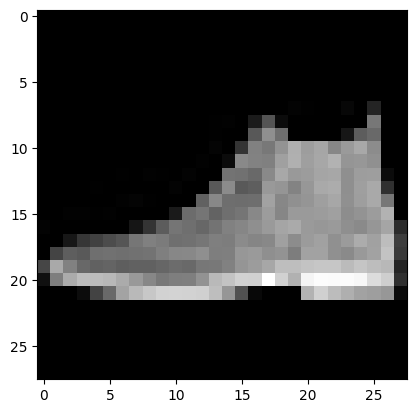

In [32]:
# Testing with individual images
print("Length of Test Datasets: ", len(test_dataset))
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("Shape: ", img.shape)
print('Label: ', label)

In [33]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

In [34]:
img, label = test_dataset[0]
print('Label:', label, ', Predicted :', predict_image(img, model))

Label: 9 , Predicted : 9


In [35]:
# the final check on the test dataset (not used in any training)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8975551724433899, 'val_acc': 0.707812488079071}

# Convolutional Neural Network (CNN)
So far we treated the MNIST data by flatting each image into a vector. However, there's a lot of information embedded in spatial information. In order to fully `understand' the image, we need to consider its 2 or more dimensions. Convolutional layers help us in this regard. In most of cases, CNN outperforms densely connected networks and is the most popular architecture for imaging analysis.

CNN is the main force behind revolutionizing the AI or deep learning in the recent decade. Deep neural networks using CNN has shown unprecedented performances when they were first introduced at many competitions (e.g., the ImageNet) by large margins. For imaging analysis, CNN remains the mainstay.

Looking ahead, there are more recent architectures such as the transformer and the diffusion model. We won't be convering them in this course ;)

Convolutional layer is implemented in pytorch as **nn.Conv2d**. As you can see, it is essentially a drop in replacement for nn.Linear and other classes.

The explanation for the pytorch class **nn.Conv2d**.

in_channels (int) — Number of channels in the input image, 1 for a grayscale image

out_channels (int) — Number of channels produced by the convolution

kernel_size (int or tuple) — Size of the convolving kernel

stride (int or tuple, optional) — Stride of the convolution. Default: 1

padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1

groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) — If True, adds a learnable bias to the output. Default: True

Adapted from [@nutanbhogendrasharma](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118)



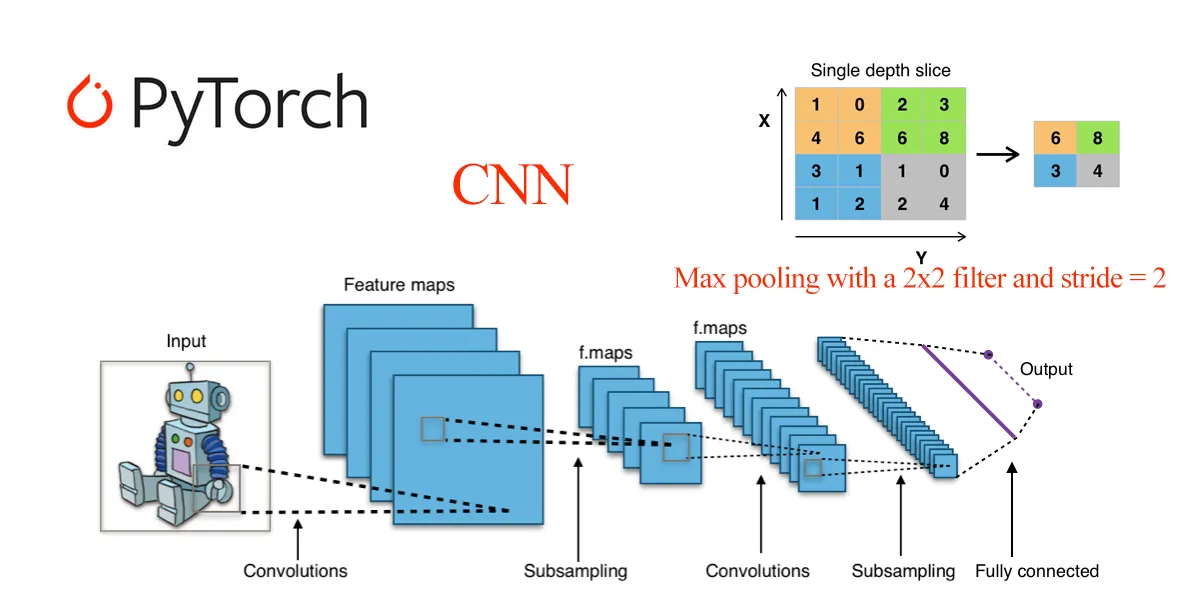

In [118]:
# We construct a fundamental CNN class.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [119]:
# train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
# ## Print the length of train and validation datasets
# print("length of Train Datasets: ", len(train_data))
# print("length of Validation Datasets: ", len(validation_data))

# batch_size = 128
# train_loader = DataLoader(train_data, batch_size, shuffle = True)
# val_loader = DataLoader(validation_data, batch_size, shuffle = False)
from torch.autograd import Variable

def train(num_epochs, cnn, loaders):
    history = []

    cnn.train()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
    loss_func = nn.CrossEntropyLoss()
    # Train the model
    total_step = len(loaders)

    for epoch in range(num_epochs):
        epoch_loss = 0

        for i, (images, labels) in enumerate(loaders):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()
            # accumulate loss
            epoch_loss += loss.item()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
        # return history
        avg_loss = epoch_loss / len(loaders)
        history.append(avg_loss)
    
    return history

In [120]:
history0 = train(num_epochs=10, cnn=cnn, loaders=train_loader)

Epoch [1/10], Step [100/391], Loss: 0.4059
Epoch [1/10], Step [200/391], Loss: 0.3210
Epoch [1/10], Step [300/391], Loss: 0.2185
Epoch [2/10], Step [100/391], Loss: 0.2806
Epoch [2/10], Step [200/391], Loss: 0.2698
Epoch [2/10], Step [300/391], Loss: 0.4387
Epoch [3/10], Step [100/391], Loss: 0.3317
Epoch [3/10], Step [200/391], Loss: 0.2111
Epoch [3/10], Step [300/391], Loss: 0.3213
Epoch [4/10], Step [100/391], Loss: 0.3263
Epoch [4/10], Step [200/391], Loss: 0.2631
Epoch [4/10], Step [300/391], Loss: 0.3934
Epoch [5/10], Step [100/391], Loss: 0.2110
Epoch [5/10], Step [200/391], Loss: 0.2550
Epoch [5/10], Step [300/391], Loss: 0.2673
Epoch [6/10], Step [100/391], Loss: 0.2470
Epoch [6/10], Step [200/391], Loss: 0.3646
Epoch [6/10], Step [300/391], Loss: 0.3305
Epoch [7/10], Step [100/391], Loss: 0.1801
Epoch [7/10], Step [200/391], Loss: 0.2913
Epoch [7/10], Step [300/391], Loss: 0.2333
Epoch [8/10], Step [100/391], Loss: 0.2011
Epoch [8/10], Step [200/391], Loss: 0.1110
Epoch [8/10

Text(0.5, 1.0, 'Losses over epochs')

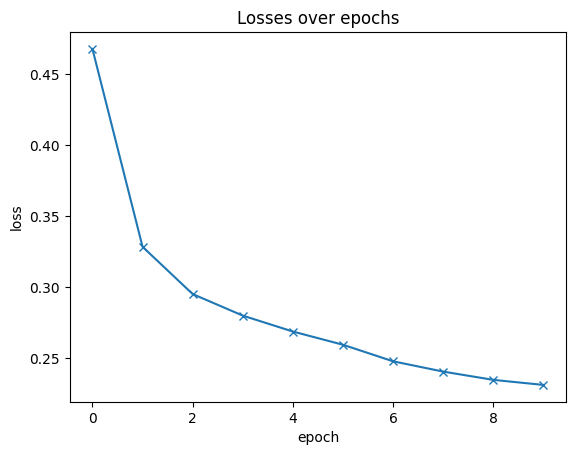

In [121]:
plt.plot(history0, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses over epochs')

# Evaluate the model on test data

We must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. model.train() set layers like dropout, batchnorm etc. to behave for training.

You can call either model.eval() or model.train(mode=False) to tell that you are testing the model.

In [ ]:
def evaluate_model(cnn, data_loader, dataset_name=""):
    cnn.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            outputs, _ = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    if dataset_name:
        print(f'Model accuracy on {dataset_name}: {accuracy:.2f}')

In [123]:
evaluate_model(cnn, train_loader, "training set")
evaluate_model(cnn, test_loader, "test set")

Model accuracy on training set: 0.92
Model accuracy on test set: 0.88


0.8832

Run inference on individual images

In [124]:
sample = next(iter(test_loader))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [9 2 1 1 6 1 4 6 5 7]
Actual number: [9 2 1 1 6 1 4 6 5 7]


#  **Improving architecture of CNN model**

## Model version #1

Changes:
- increased channels from 16 to 32
- added batch normalization
- added dropout layers to reduce overfitting

In [61]:
class CNN_v1(nn.Module):
    def __init__(self):
        super(CNN_v1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1, 2),
            nn.BatchNorm2d(32),         
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)           
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1, 2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.out = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

cnn_v1 = CNN_v1()
print(cnn_v1)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [126]:
history1 = train(num_epochs=10, cnn=cnn_v1, loaders=train_loader)

Epoch [1/10], Step [100/391], Loss: 0.1784
Epoch [1/10], Step [200/391], Loss: 0.2413
Epoch [1/10], Step [300/391], Loss: 0.1988
Epoch [2/10], Step [100/391], Loss: 0.3019
Epoch [2/10], Step [200/391], Loss: 0.2584
Epoch [2/10], Step [300/391], Loss: 0.1735
Epoch [3/10], Step [100/391], Loss: 0.1715
Epoch [3/10], Step [200/391], Loss: 0.1943
Epoch [3/10], Step [300/391], Loss: 0.1587
Epoch [4/10], Step [100/391], Loss: 0.2778
Epoch [4/10], Step [200/391], Loss: 0.2643
Epoch [4/10], Step [300/391], Loss: 0.2734
Epoch [5/10], Step [100/391], Loss: 0.2479
Epoch [5/10], Step [200/391], Loss: 0.2125
Epoch [5/10], Step [300/391], Loss: 0.1524
Epoch [6/10], Step [100/391], Loss: 0.2372
Epoch [6/10], Step [200/391], Loss: 0.1827
Epoch [6/10], Step [300/391], Loss: 0.2491
Epoch [7/10], Step [100/391], Loss: 0.1598
Epoch [7/10], Step [200/391], Loss: 0.1463
Epoch [7/10], Step [300/391], Loss: 0.1140
Epoch [8/10], Step [100/391], Loss: 0.1366
Epoch [8/10], Step [200/391], Loss: 0.1325
Epoch [8/10

Text(0.5, 1.0, 'Losses over epochs')

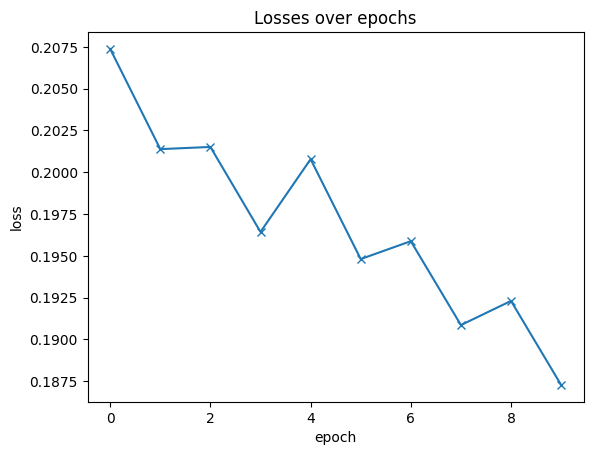

In [127]:
plt.plot(history1, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses over epochs')

In [128]:
evaluate_model(cnn_v1, train_loader, "training set")
evaluate_model(cnn_v1, test_loader, "test set")

Model accuracy on training set: 0.95
Model accuracy on test set: 0.91


0.9061

## Model version #2 -  Deeper architecture

I took first model and added such changes:
- added one more convolutional layer
- made kernels smaller (3x3)

In [94]:
class CNN_v2(nn.Module):
    def __init__(self):
        super(CNN_v2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 2),
            nn.BatchNorm2d(32),         
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)           
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.out = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

cnn_v2 = CNN_v2()
print(cnn_v2)

CNN_v2(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  

In [95]:
history2 = train(num_epochs=10, cnn=cnn_v2, loaders=train_loader)

Epoch [1/10], Step [100/391], Loss: 0.4994
Epoch [1/10], Step [200/391], Loss: 0.6619
Epoch [1/10], Step [300/391], Loss: 0.2950
Epoch [2/10], Step [100/391], Loss: 0.3807
Epoch [2/10], Step [200/391], Loss: 0.3498
Epoch [2/10], Step [300/391], Loss: 0.4571
Epoch [3/10], Step [100/391], Loss: 0.3047
Epoch [3/10], Step [200/391], Loss: 0.3870
Epoch [3/10], Step [300/391], Loss: 0.3633
Epoch [4/10], Step [100/391], Loss: 0.2750
Epoch [4/10], Step [200/391], Loss: 0.2017
Epoch [4/10], Step [300/391], Loss: 0.3345
Epoch [5/10], Step [100/391], Loss: 0.3630
Epoch [5/10], Step [200/391], Loss: 0.1540
Epoch [5/10], Step [300/391], Loss: 0.2303
Epoch [6/10], Step [100/391], Loss: 0.2679
Epoch [6/10], Step [200/391], Loss: 0.2491
Epoch [6/10], Step [300/391], Loss: 0.2961
Epoch [7/10], Step [100/391], Loss: 0.2195
Epoch [7/10], Step [200/391], Loss: 0.3242
Epoch [7/10], Step [300/391], Loss: 0.3033
Epoch [8/10], Step [100/391], Loss: 0.2431
Epoch [8/10], Step [200/391], Loss: 0.2679
Epoch [8/10

Text(0.5, 1.0, 'Losses over epochs')

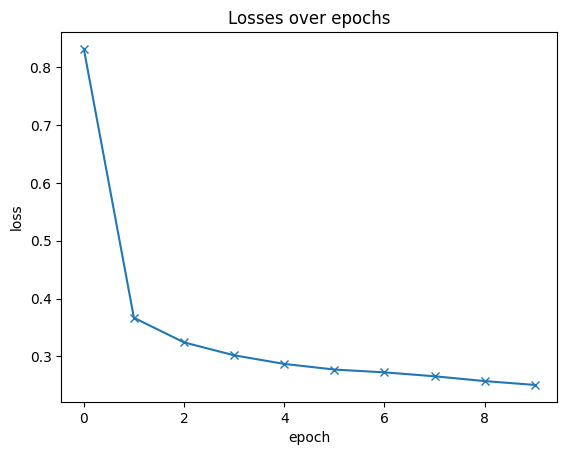

In [111]:
plt.plot(history2, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses over epochs')

In [113]:
evaluate_model(cnn_v2, train_loader, "training set")
evaluate_model(cnn_v2, test_loader, "test set")

Model accuracy on training set: 0.92
Model accuracy on test set: 0.90


0.901

## Model version #3 -  Futher advancing

Applied changes on model #2:
- modified fully-connected block with higher dropout

In [114]:
class CNN_v3(nn.Module):
    def __init__(self):
        super(CNN_v3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 2),
            nn.BatchNorm2d(32),         
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)           
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.fc_block = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.fc_block(x)
        return output, x

cnn_v3 = CNN_v3()
print(cnn_v3)

CNN_v3(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  

In [115]:
history3 = train(num_epochs=10, cnn=cnn_v3, loaders=train_loader)

Epoch [1/10], Step [100/391], Loss: 0.5660
Epoch [1/10], Step [200/391], Loss: 0.4091
Epoch [1/10], Step [300/391], Loss: 0.2615
Epoch [2/10], Step [100/391], Loss: 0.3511
Epoch [2/10], Step [200/391], Loss: 0.3750
Epoch [2/10], Step [300/391], Loss: 0.4497
Epoch [3/10], Step [100/391], Loss: 0.3665
Epoch [3/10], Step [200/391], Loss: 0.4308
Epoch [3/10], Step [300/391], Loss: 0.2475
Epoch [4/10], Step [100/391], Loss: 0.2589
Epoch [4/10], Step [200/391], Loss: 0.2554
Epoch [4/10], Step [300/391], Loss: 0.3904
Epoch [5/10], Step [100/391], Loss: 0.2149
Epoch [5/10], Step [200/391], Loss: 0.2972
Epoch [5/10], Step [300/391], Loss: 0.3337
Epoch [6/10], Step [100/391], Loss: 0.4120
Epoch [6/10], Step [200/391], Loss: 0.3713
Epoch [6/10], Step [300/391], Loss: 0.2450
Epoch [7/10], Step [100/391], Loss: 0.2942
Epoch [7/10], Step [200/391], Loss: 0.2368
Epoch [7/10], Step [300/391], Loss: 0.3519
Epoch [8/10], Step [100/391], Loss: 0.1648
Epoch [8/10], Step [200/391], Loss: 0.3201
Epoch [8/10

Text(0.5, 1.0, 'Losses over epochs')

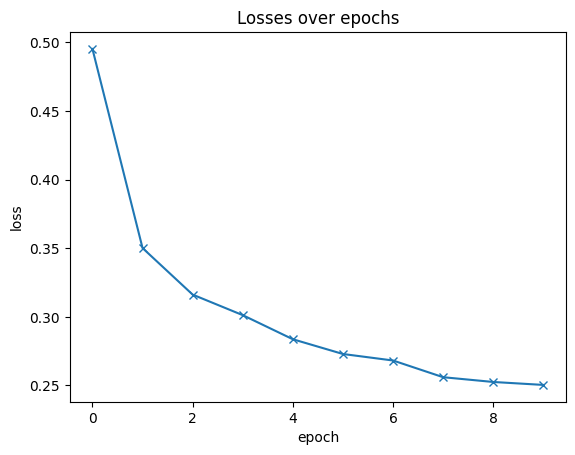

In [116]:
plt.plot(history3, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses over epochs')

In [117]:
evaluate_model(cnn_v3, train_loader, "training set")
evaluate_model(cnn_v3, test_loader, "test set")

Model accuracy on training set: 0.93
Model accuracy on test set: 0.91


0.912

# Conclusions

For the second part of the homework, I constructed and evaluated three CNN models with progressively more complex architectures:
1. CNN_v1
    - Two convolutional layers

    - Increased channels (16 -> 32 in first layer)

    - Added batch normalization

    - Introduced dropout layers (25%)

    *Achieved accuracy: 90.61%*

2. CNN_v2
    - Three convolutional layers

    - Reduced kernel size (5x5 -> 3x3)

    *Achieved accuracy: 90.1%*

3. CNN_v3
    - Three convolutional layers

    - Added enhanced fully-connected block (FC)

    - Increased dropout (50% in FC layers)

    *Achieved accuracy 91.2%*

To compare, baseline CNN architecure has 88.32% ACC and DNN has 70% ACC.

All models converged to similar accuracy (90-91%), suggesting that the MNIST Fashion dataset may not require such complex architectures to achieve good performance and CNN_v1 (that was better than baseline architecture) was already sufficient for this task. Also additional complexity didn't degrade performance, thanks to regularization preventing overfitting.